_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

# 1. PreProcessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce


In [3]:
train.columns


Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [4]:
train['Zip'] = train['Zip'].ffill()

In [5]:
train['Zip'].isnull().value_counts()

False    51916
Name: Zip, dtype: int64

In [6]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [7]:
X_train = train.drop('Fail', axis=1)
y_train = train['Fail']

X_test = test.drop('Fail', axis=1)
y_test = test['Fail']

In [8]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
State,51906,1,IL,51906
Risk,51904,3,Risk 1 (High),37731
City,51863,39,CHICAGO,51659
Inspection Type,51915,51,Canvass,24170
Facility Type,51692,329,Restaurant,34264
Inspection Date,51916,2257,2017-03-23T00:00:00,50
Location,51718,13410,"{'longitude': '-87.91442843927047', 'latitude'...",741
Address,51916,13954,11601 W TOUHY AVE,741
AKA Name,51293,16350,SUBWAY,802
DBA Name,51916,17049,SUBWAY,654


In [9]:
feature = ['Risk', 'City', 'Inspection Type', 'Facility Type']

In [10]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[feature])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head()

1 column, Risk                 4
City                40
Inspection Type     52
Facility Type      330
dtype: int64 unique values


,Risk,City,Inspection Type,Facility Type
0,1,1,1,1
1,2,1,2,2
2,1,1,3,1
3,3,1,1,1
4,1,1,1,3


In [11]:
encoded['Violations'] = len(X_train['Violations'])

In [12]:
encoded['Zip'] = train['Zip']

In [13]:
train['Latitude'] = train['Latitude'].ffill()
train['Longitude'] = train['Longitude'].ffill()

In [14]:
encoded['Loc'] = train['Latitude'] * train['Longitude']

In [15]:
encoded['riskInspection Type'] = encoded['Risk'] * encoded['Inspection Type']

# 2. Model

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(), encoded, y_train,
                        scoring='neg_mean_absolute_error', cv=3,
                        return_train_score=True, return_estimator=True, error_score='raise')

In [18]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.026022,0.002080,"LinearRegression(copy_X=True, fit_intercept=Tr...",-0.380952,-0.379061
1,0.005893,0.001507,"LinearRegression(copy_X=True, fit_intercept=Tr...",-0.379980,-0.381450
2,0.005585,0.001331,"LinearRegression(copy_X=True, fit_intercept=Tr...",-0.380208,-0.380414


In [19]:
for i, model in enumerate(scores['estimator']):
    #print(i, ' ', model)
    coefficients = model.coef_
    intercept = model.intercept_
    feature_names = encoded.columns
    
    print(f'Model from cross-validation fold #{i}')
    print('Intercept', intercept)
    print(pd.Series(coefficients, feature_names).to_string())
    print('\n')
    

Model from cross-validation fold #0
Intercept -14.78577980906509
Risk                  -5.780065e-03
City                  -3.757043e-03
Inspection Type        7.959050e-03
Facility Type          1.559192e-04
Violations            -3.469447e-18
Zip                    2.972222e-04
Loc                    8.188177e-04
riskInspection Type    3.420023e-03


Model from cross-validation fold #1
Intercept -14.832889899870105
Risk                  -7.797982e-03
City                  -5.397340e-03
Inspection Type        6.510800e-03
Facility Type          2.656542e-04
Violations             3.903128e-18
Zip                    2.974264e-04
Loc                    8.066071e-04
riskInspection Type    3.549061e-03


Model from cross-validation fold #2
Intercept -21.34826189112726
Risk                  -5.181945e-03
City                  -2.519008e-03
Inspection Type        7.152727e-03
Facility Type          1.201665e-04
Violations            -8.673617e-19
Zip                    3.864492e-04
Loc     

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, max_depth=None, n_jobs=-1)

scores = cross_validate(model, encoded, y_train,
                        scoring='neg_mean_absolute_error',
                        cv = 3, return_train_score=True,
                        return_estimator=True)
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,1.886244,0.105636,"(DecisionTreeClassifier(class_weight=None, cri...",-0.307119,-0.086391
1,0.785136,0.103776,"(DecisionTreeClassifier(class_weight=None, cri...",-0.304767,-0.087631
2,0.812557,0.103993,"(DecisionTreeClassifier(class_weight=None, cri...",-0.301185,-0.085377


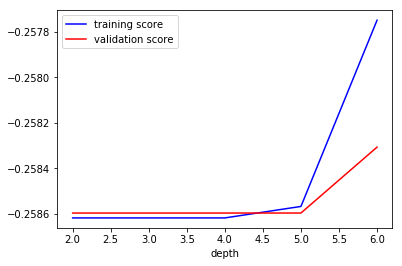

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestClassifier(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, encoded, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [22]:
from sklearn.metrics import roc_auc_score


In [23]:
pd.DataFrame(scores)['estimator'][0].predict(encoded)

array([0, 1, 0, ..., 0, 0, 0])

In [24]:
print(roc_auc_score(y_train,pd.DataFrame(scores)['estimator'][0].predict(encoded)))

0.7677568006795484


In [25]:
list(encoded.columns)

['Risk',
 'City',
 'Inspection Type',
 'Facility Type',
 'Violations',
 'Zip',
 'Loc',
 'riskInspection Type']

# 3. Visualization

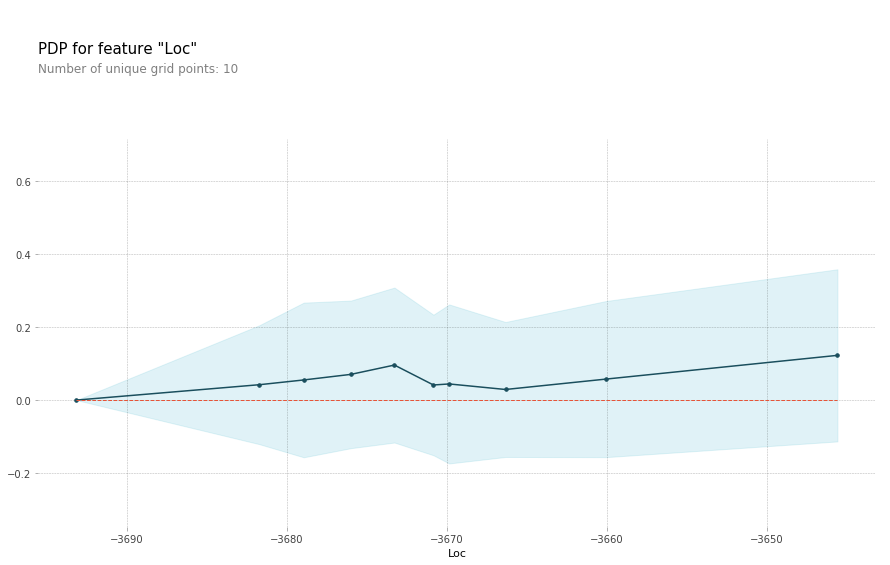

In [26]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature =  'Loc'
isolated = pdp_isolate(
    model=pd.DataFrame(scores)['estimator'][0], 
    dataset=encoded, 
    model_features=encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

# 4. Gradient Descent

- What does Gradient Descent seek to minimize?
-- Gradient Descent seeks to minimize the result of a given Formula.
-- (It minimizes the y of a given y = f(x)

- What is the "Learning Rate" and what is its function?
-- Learning Rate is what determines how quickly the the descent minimizes the function.
-- The function of the learning rate, is to set how much the value moves twards the minimum.
